In [1]:
import pickle
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import torch

from policy import DPAgent
from simulation import Simulator, CustomerGenerator
from hazard_models import ExponentialHazard
from utility_learner import ProjectedVolumeLearner, diam
from degradation_learner import DegradationLearner

from utils import unit_ball_rejection_sample, correct_signs
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

import logging
logging.basicConfig(level=logging.INFO)

np.set_printoptions(suppress=True)

In [2]:
# --- 2. Define Sampling Functions ---
# def context_sampler() -> np.ndarray:
#     """Samples a customer's context vector from a uniform distribution."""
#     return np.random.uniform(low=0.0, high=1.0, size=D)

def context_sampler() -> np.ndarray:
    """Samples a customer's context vector uniformly from the unit ball."""
    return np.abs(unit_ball_rejection_sample(D))

def rental_sampler() -> float:
    """Samples a customer's desired rental duration from an exponential distribution."""
    return np.random.exponential(scale=10.0)

def interarrival_sampler() -> float:
    """Samples the time until the next customer arrives."""
    return np.random.exponential(scale=5.0)

In [3]:
# --- 1. Simulation Configuration ---
D = 4                                  # Dimension of context vectors
LAMBDA_VAL = 0.001                     # Baseline hazard constant
NUM_CUSTOMERS = 100000                   # Total number of customers to simulate, i.e. T

# Set a random seed for reproducibility
np.random.seed(41)

# Ground truth vectors
THETA_TRUE = np.array([0.5, 0.2, 0.1, 0.3])#$, 0.4])    # For degradation
UTILITY_TRUE = context_sampler()  # For customer's willingness to pay

# --- Machine's Pricing Vector 'r' ---
# This is a fallback pricing vector, when we don't feed u_hat to calculate_price
PRICING_R = np.zeros(D)

In [4]:
usage_exp_hazard_model = ExponentialHazard(lambda_val=LAMBDA_VAL)
# spontaneous_exp_hazard_model = None # ExponentialHazard(lambda_val=0.01)

customer_gen = CustomerGenerator(
    d=D,
    context_sampler=context_sampler,
    rental_sampler=rental_sampler,
    interarrival_sampler=interarrival_sampler
)

centroid_params = {
    # 'num_samples': 2000,
    # 'thin': None,
    # 'burn_in': 500 * D ** 2,
    # 'tol': 1e-4,
    # 'rho_target': 0.01
}

termination_rule = lambda diameter: diameter < 0.0005  # Example custom termination rule

projected_volume_learner = ProjectedVolumeLearner(
    T=NUM_CUSTOMERS, 
    d=D, 
    centroid_params=centroid_params,
    incentive_constant=1.1,
    termination_rule=termination_rule,
)

mdp_params = {
    'replacement_cost': 1.5,   # Cost to replace the machine
    'failure_cost': 0.75,      # Additional penalty for in-service failure
    'holding_cost_rate': 0.02,   # Cost per unit of idle time
    'gamma': 0.99,             # Discount factor
    'learning_rate': 1e-3,      # Learning rate for the Adam optimizer
    'target_update_freq': 10    # How often to update the target network (in iterations)
}

training_hyperparams = {
    'num_iterations': 50, # Number of training iterations per policy update
    'dataset_size': 500000,      # Number of transitions to generate for the offline dataset
    'batch_size': 2048           # Batch size for training
}

policy_params = {
    'type': 'softmax',
    'tau': 1.0,
    'epsilon': 0.1,
}

# Instantiate the Simulator with the new parameters
simulator = Simulator(
    d=D,
    T=NUM_CUSTOMERS,
    
    theta_true=THETA_TRUE,
    utility_true=UTILITY_TRUE,
    pricing_r=PRICING_R,
    
    usage_hazard_model=usage_exp_hazard_model,
    customer_generator=customer_gen,
    projected_volume_learner=projected_volume_learner,  # Use default ProjectedVolumeLearner
    
    mdp_params=mdp_params,
    training_hyperparams=training_hyperparams,
    policy_params=policy_params,
    policy_update_threshold=5,
    time_normalize=True,
)

In [5]:
# simulator.projected_volume_learner.is_terminated = True
simulation_data = simulator.run(num_customers=NUM_CUSTOMERS)
degradation_df = pd.DataFrame(simulator.degradation_history)
simulation_df = pd.DataFrame(simulator.history)

INFO:root:Starting simulation for 100000 customers...
  0%|          | 0/100000 [00:00<?, ?it/s]

Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2651514


INFO:gurobipy:Set parameter LicenseID to value 2651514


Academic license - for non-commercial use only - expires 2026-04-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-04-14
  0%|          | 0/100000 [00:01<?, ?it/s]


KeyboardInterrupt: 

## Training policy under perfect information

In [ ]:
class PerfectDegradationLearner:
    def __init__(self, d, theta_true, hazard_model):
        self.d = d
        self.theta_true = theta_true
        self.hazard_model = hazard_model  # Placeholder, not used
        
    def get_theta(self):
        return self.theta_true
    
    def cum_baseline(self, t):
        return self.hazard_model.Lambda_0(t)
    
    def inverse_cum_baseline(self, u):
        return self.hazard_model.Lambda_0_inverse(u)
    
perfect_degradation_learner = PerfectDegradationLearner(
    d=D, 
    theta_true=THETA_TRUE,
    hazard_model=usage_exp_hazard_model,
)
perfect_dpagent = DPAgent(
    d=D,
    u_hat=UTILITY_TRUE,
    time_normalize=True,
    degradation_learner=perfect_degradation_learner,
    customer_generator=customer_gen,
    params=mdp_params,
)

# perfect_dpagent.train(
#     num_iterations=50,
#     dataset_size=500000,
#     batch_size=1024
# )

# perfect_policy.q_network.save_state_dict('perfect_dpagent_q_network.pth')

perfect_dpagent.q_network.load_state_dict(
    torch.load('perfect_dpagent_q_network.pth', map_location=perfect_dpagent.device)
)
perfect_dpagent.q_network.eval()

policy = perfect_dpagent.get_policy(
    {'type': 'greedy', 'epsilon': 0.0, 'tau': 1.0}
)

Using device: mps


In [11]:
num_repeat = 10
histories = []

for _ in range(num_repeat):
    history = simulator.run_full_exploit(10000, policy)
    history = pd.DataFrame(history)
    
    history['net_profit'] = history['profit'] + history['loss']
    # calculate cumulative profit and loss
    history['cumulative_net_profit'] = history['net_profit'].cumsum()
    histories.append(history)


INFO:root:Starting simulation for 10000 customers...
100%|██████████| 10000/10000 [00:08<00:00, 1112.27it/s]
INFO:root:Simulation finished.
INFO:root:Starting simulation for 10000 customers...
100%|██████████| 10000/10000 [00:08<00:00, 1156.94it/s]
INFO:root:Simulation finished.
INFO:root:Starting simulation for 10000 customers...
100%|██████████| 10000/10000 [00:08<00:00, 1180.75it/s]
INFO:root:Simulation finished.
INFO:root:Starting simulation for 10000 customers...
100%|██████████| 10000/10000 [00:09<00:00, 1102.64it/s]
INFO:root:Simulation finished.
INFO:root:Starting simulation for 10000 customers...
100%|██████████| 10000/10000 [00:08<00:00, 1152.96it/s]
INFO:root:Simulation finished.
INFO:root:Starting simulation for 10000 customers...
100%|██████████| 10000/10000 [00:08<00:00, 1164.50it/s]
INFO:root:Simulation finished.
INFO:root:Starting simulation for 10000 customers...
100%|██████████| 10000/10000 [00:08<00:00, 1217.42it/s]
INFO:root:Simulation finished.
INFO:root:Starting s

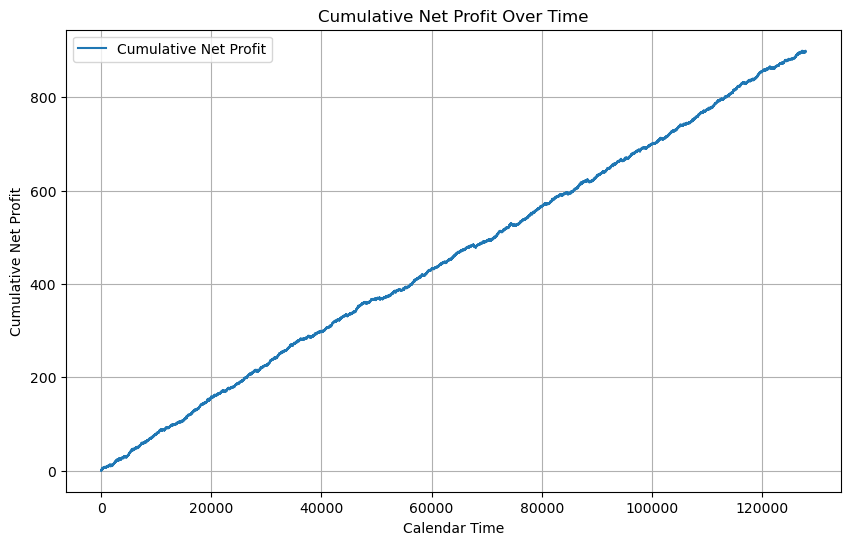

In [9]:
ax = plt.figure(figsize=(10,6))

# plot cumulative profit and loss over time
plt.plot(history['calendar_time'], history['cumulative_net_profit'], label='Cumulative Net Profit')
plt.xlabel('Calendar Time')
plt.ylabel('Cumulative Net Profit')
plt.title('Cumulative Net Profit Over Time')
plt.legend()
plt.grid()
plt.show()

### Debugging: Look at experience dataset

In [ ]:
from policy import DPAgent

print(simulator.projected_volume_learner.get_estimate())
print(UTILITY_TRUE)

dp_agent = DPAgent(
    d=simulator.d,
    u_hat=simulator.projected_volume_learner.get_estimate(),
    time_normalize=simulator.time_normalize,
    degradation_learner=simulator.degradation_learner,
    customer_generator=simulator.customer_generator,
    params=simulator.mdp_params
)

dataset = dp_agent.experience_generator.generate(500)

for data in dataset:
    state, action, reward, next_state = data
    print("State:", state.round(3))
    print("Action:", dp_agent.experience_generator.ACTION_MAP[action])
    print("Reward:", reward)
    print("Next State:", next_state.round(3))
    print("-----")
    print()

In [ ]:
degradation_learner = DegradationLearner(d=D, initial_theta=np.zeros(D))
degradation_df = pd.DataFrame(simulator.degradation_history)
degradation_learner.fit(degradation_df)
degradation_learner.get_theta()

Testing Policy

In [ ]:
i = 50

X_i = df.loc[i, 'sum_of_contexts_after']
I_i = 3 # df.loc[i, '']
x_i = df.loc[i+1, 'customer_context']
T_i = df.loc[i+1, 'rental_duration']

arrival_state = np.concatenate([
    X_i,
    x_i,
    [T_i, I_i, 0.0]
])
action_arrival = optimal_policy(arrival_state)
action_map = {0: 'Give Max Acceptable Price', 1: 'Shutdown'}
print(f"Sample Arrival State. Optimal Action: {action_map[action_arrival]}")


In [ ]:
# Test Case 2: Departure State
departure_state = np.concatenate([
    X_i+x_i*10, 
    np.zeros(D), 
    [0.0, I_i, 1.0]
])
action_departure = optimal_policy(departure_state)
action_map = {2: 'Replace Machine', 3: 'Do Not Replace'}
print(f"Sample Departure State. Optimal Action: {action_map[action_departure]}")
